In [3]:
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np 
import pandas as pd
from scipy.integrate import dblquad 

In [4]:
toa_olw = xr.open_dataset('/Users/meb/Downloads/outgoing.nc')
toa_osw = xr.open_dataset('/Users/meb/Downloads/outgoingsw.nc')
toa_isw = xr.open_dataset('/Users/meb/Downloads/incomingsw.nc')
surf_olw = xr.open_dataset('/Users/meb/Downloads/surfaceoutgoinglw.nc')
surf_osw = xr.open_dataset('/Users/meb/Downloads/surfaceoutoingsw.nc')
surf_ilw = xr.open_dataset('/Users/meb/Downloads/surfaceincominglw.nc')
surf_isw = xr.open_dataset('/Users/meb/Downloads/surfaceincomingsw.nc')
cld_area = xr.open_dataset('/Users/meb/Downloads/cloudcoverarea%.nc')
cld_teff = xr.open_dataset('/Users/meb/Downloads/cloudteff.nc')

In [121]:
#creating an array of weights for each lat-long section 
k = np.pi/180
lat = np.arange(-89.5, 90, 1)
lon = np.arange(0.5, 360, 1)
def weight(lt, ln):
    ut = (lt+0.5)*k
    lt = (lt - 0.5)*k
    up = (ln + 0.5)*k
    lp = (ln - 0.5)*k
    f = lambda phi, theta: (np.cos(theta))/(4*np.pi)
    return dblquad(f, lt, ut,lp, up)
weights =[]
for tit in lat:
    col =[]
    for git in lon:
        w = weight(tit, git)
        col.append(w[0])
    weights.append(col)
#dblquad returns a tuple, if you directly put that into a data array with two coordinates (lat and long)
#it won't work cause you have to have to add another coordinate specifying which element in the tuple you want then
da = xr.DataArray(data=weights, dims=["lat", "lon"], coords=[lat,lon])

In [157]:
#el nino mask - el nino years being 2014,2015,and 2018
onlydec = toa_olw['time.month'] == 12
el2014 = toa_olw['time.year']== 2014
el2015 = toa_olw['time.year']== 2015
el2018 = toa_olw['time.year']== 2018
elmask = el2014 + el2015 + el2018
mask1 = elmask*onlydec 
mask2 = np.invert(elmask)*onlydec
tahiti_lat = -17.6509
tahiti_lon = -149.4260
darwin_lat = -12.4637
darwin_lon = 130.8444

In [228]:
def cleanupnino2D(a):
    elnino = a.groupby(mask1).apply(timemean).sel(group = True)
    climatology = a.groupby(onlydec).apply(timemean).sel(month = True)
    ninodev = elnino - climatology
    p = ninodev.to_array()
    q = p.squeeze()
    return q
#group el nino decembers, average variable over year, calculate deviation from climatology
def cleanupnina2D(a):
    lanina = a.groupby(mask2).apply(timemean).sel(group = True)
    climatology = a.groupby(onlydec).apply(timemean).sel(month = True)
    ninadev = lanina - climatology
    r = ninadev.to_array()
    s = r.squeeze()
    return s
#group la nina decembers, average over year, calculate deviation from climatology
def lonmean(a):
    return a.mean(dim = ['time','lon'])
def cleanupnino1D(a):
    elnino = a.groupby(mask1).apply(lonmean).sel(group = True)
    climatology = a.groupby(onlydec).apply(lonmean).sel(month = True)
    ninodev = elnino - climatology
    e = ninodev.to_array()
    f = e.squeeze()
    return f
#group el nino decembers, average variable over longitude and year, calculate deviation from climatology for all lat
def cleanupnina1D(a):
    elnino = a.groupby(mask2).apply(lonmean).sel(group = True)
    climatology = a.groupby(onlydec).apply(lonmean).sel(month = True)
    ninadev = elnino - climatology
    g = ninadev.to_array()
    h = g.squeeze()
    return h
def timemean(a):
    return a.mean(dim= ['time'])
#average data over year 
def pearsoncorr(a,b):
    ninoa = a.groupby(mask1).apply(timemean).sel(group = True)
    ninob = b.groupby(mask1).apply(timemean).sel(group = True)
    e = ninoa.to_array()
    f = ninob.to_array()
    cor = xr.corr(e,f)
    return cor

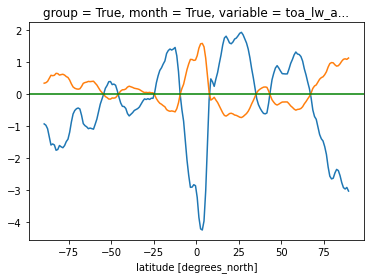

In [198]:
%matplotlib notebook
%matplotlib inline
p = cleanupnino1D(toa_olw)
q = cleanupnina1D(toa_olw)
p.plot.line(x = 'lat')
q.plot.line(x= 'lat')
plt.axhline(y = 0, color = 'green')
plt.savefig('toa_olr_latdev')
plt.show()
#blue - el nino deviation of top of the atmosphere outgoing longwave radiation from climatology
#orange- la nina deviation from climatology

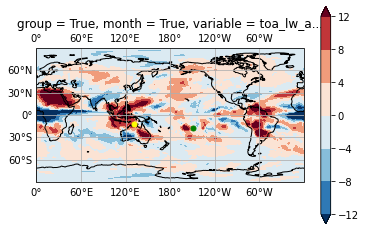

In [200]:
p = cleanupnino2D(toa_olw)
%matplotlib notebook
%matplotlib inline
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude = 180 ))
p.plot.contourf(robust = True)
ax.coastlines()
plate_carree = ccrs.PlateCarree(central_longitude=180)
ax.plot(tahiti_lon, tahiti_lat, markersize=5, marker='o', color='green', transform=ccrs.PlateCarree())
ax.plot(darwin_lon, darwin_lat, markersize=5, marker='o', color='yellow', transform=ccrs.PlateCarree())
plt.gca().gridlines(draw_labels=True)
plt.savefig('toa_olr_nino_2D')
plt.show()
#green dot - Tahiti, yellow dot - Darwin
#deviation of toa olr averaged over different years during el nino decembers 

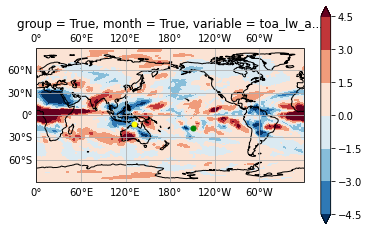

In [201]:
q = cleanupnina2D(toa_olw)
%matplotlib notebook
%matplotlib inline
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude = 180))
q.plot.contourf(robust= True)
ax.coastlines()
plate_carree = ccrs.PlateCarree(central_longitude=180)
ax.plot(tahiti_lon, tahiti_lat, markersize=5, marker='o', color='green', transform=ccrs.PlateCarree())
ax.plot(darwin_lon, darwin_lat, markersize=5, marker='o', color='yellow', transform=ccrs.PlateCarree())
plt.gca().gridlines(draw_labels=True)
plt.savefig('toa_olr_nina_2D')
plt.show()
#green dot - Tahiti, yellow dot - Darwin
#deviation of toa olr averaged over different years during la nina decembers 

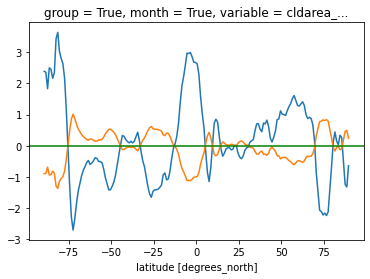

In [202]:
%matplotlib notebook
%matplotlib inline
nino = cleanupnino1D(cld_area)
nina = cleanupnina1D(cld_area)
nino.plot.line(x = 'lat')
nina.plot.line(x = 'lat')
plt.axhline(y = 0, color = 'green')
plt.savefig('cld_area_latidev')
plt.show()
#blue - el nino december deviation of top cloud area from climatology
#orange- la nina ''''''

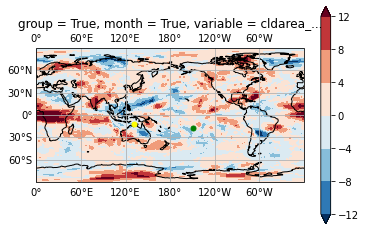

In [197]:
p = cleanupnino2D(cld_area)
%matplotlib notebook
%matplotlib inline
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude = 180))
p.plot.contourf(robust = True)
plt.gca().gridlines(draw_labels=True)
plate_carree = ccrs.PlateCarree(central_longitude=180)
ax.plot(tahiti_lon, tahiti_lat, markersize=5, marker='o', color='green', transform=ccrs.PlateCarree())
ax.plot(darwin_lon, darwin_lat, markersize=5, marker='o', color='yellow', transform=ccrs.PlateCarree())
ax.coastlines()
plt.savefig('cld_area_nino_2D')
plt.show()
#cloud area nino dec dev

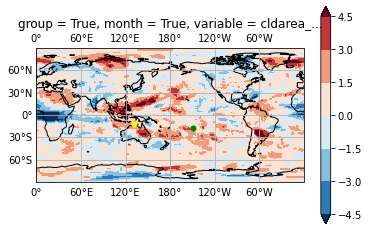

In [203]:
p = cleanupnina2D(cld_area)
%matplotlib notebook
%matplotlib inline
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude = 180))
p.plot.contourf(robust = True)
plt.gca().gridlines(draw_labels=True)
ax.coastlines()
plate_carree = ccrs.PlateCarree(central_longitude=180)
ax.plot(tahiti_lon, tahiti_lat, markersize=5, marker='o', color='green', transform=ccrs.PlateCarree())
ax.plot(darwin_lon, darwin_lat, markersize=5, marker='o', color='yellow', transform=ccrs.PlateCarree())
plt.savefig('cld_area_nina_2D')
plt.show()
#cloud area nina dec dev

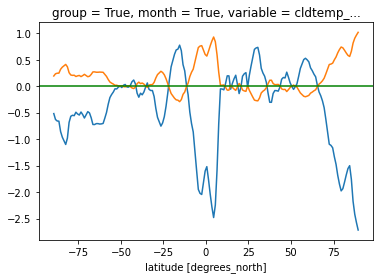

In [205]:
%matplotlib notebook
%matplotlib inline
p = cleanupnino1D(cld_teff)
q = cleanupnina1D(cld_teff)
p.plot.line(x = 'lat')
q.plot.line(x= 'lat')
plt.axhline(y = 0, color = 'green')
plt.savefig('cld_teff_latidev')
plt.show()

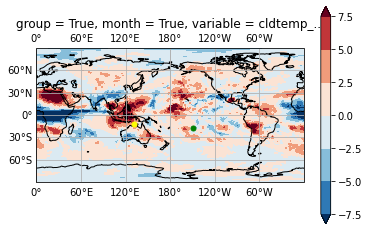

In [206]:
p = cleanupnino2D(cld_teff)
%matplotlib notebook
%matplotlib inline
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude = 180))
p.plot.contourf(robust = True)
plt.gca().gridlines(draw_labels=True)
ax.coastlines()
plate_carree = ccrs.PlateCarree(central_longitude=180)
ax.plot(tahiti_lon, tahiti_lat, markersize=5, marker='o', color='green', transform=ccrs.PlateCarree())
ax.plot(darwin_lon, darwin_lat, markersize=5, marker='o', color='yellow', transform=ccrs.PlateCarree())
plt.savefig('cld_teff_nino_2D')
plt.show()

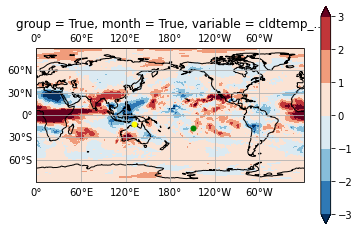

In [207]:
p = cleanupnina2D(cld_teff)
%matplotlib notebook
%matplotlib inline
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude = 180))
p.plot.contourf(robust = True)
ax.coastlines()
plate_carree = ccrs.PlateCarree(central_longitude=180)
ax.plot(tahiti_lon, tahiti_lat, markersize=5, marker='o', color='green', transform=ccrs.PlateCarree())
ax.plot(darwin_lon, darwin_lat, markersize=5, marker='o', color='yellow', transform=ccrs.PlateCarree())
plt.gca().gridlines(draw_labels=True)
plt.savefig('cld_teff_nina_2D')
plt.show()

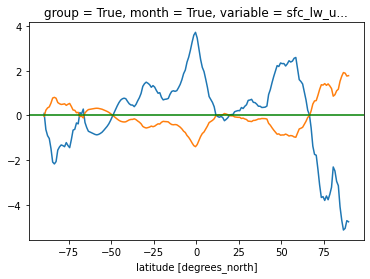

In [208]:
%matplotlib notebook
%matplotlib inline
p = cleanupnino1D(surf_olw)
q = cleanupnina1D(surf_olw)
p.plot.line(x = 'lat')
q.plot.line(x= 'lat')
plt.axhline(y = 0, color = 'green')
plt.savefig('surf_olr_latidev')
plt.show()

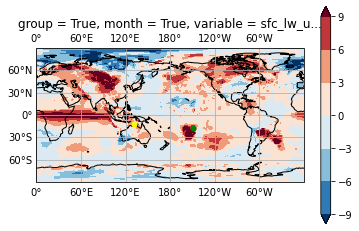

In [209]:
p = cleanupnino2D(surf_olw)
%matplotlib notebook
%matplotlib inline
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude = 180))
p.plot.contourf(robust = True)
ax.coastlines()
plate_carree = ccrs.PlateCarree(central_longitude=180)
ax.plot(tahiti_lon, tahiti_lat, markersize=5, marker='o', color='green', transform=ccrs.PlateCarree())
ax.plot(darwin_lon, darwin_lat, markersize=5, marker='o', color='yellow', transform=ccrs.PlateCarree())
plt.gca().gridlines(draw_labels=True)
plt.savefig('surf_olr_nino_2D')
plt.show()

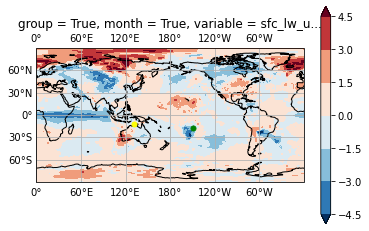

In [210]:
p = cleanupnina2D(surf_olw)
%matplotlib notebook
%matplotlib inline
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude = 180))
p.plot.contourf(robust = True)
ax.coastlines()
plate_carree = ccrs.PlateCarree(central_longitude=180)
ax.plot(tahiti_lon, tahiti_lat, markersize=5, marker='o', color='green', transform=ccrs.PlateCarree())
ax.plot(darwin_lon, darwin_lat, markersize=5, marker='o', color='yellow', transform=ccrs.PlateCarree())
plt.gca().gridlines(draw_labels=True)
plt.savefig('surf_olr_nina_2D')
plt.show()

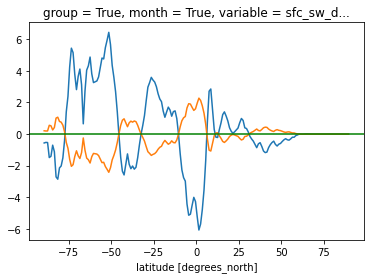

In [211]:
%matplotlib notebook
%matplotlib inline
p = cleanupnino1D(surf_isw)
q = cleanupnina1D(surf_isw)
p.plot.line(x = 'lat')
q.plot.line(x= 'lat')
plt.axhline(y = 0, color = 'green')
plt.savefig('surf_isw_latidev')
plt.show()

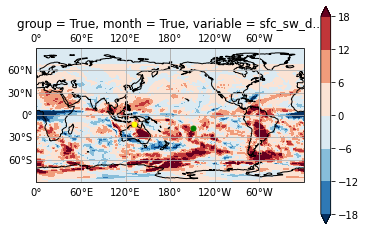

In [212]:
p = cleanupnino2D(surf_isw)
%matplotlib notebook
%matplotlib inline
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude = 180))
p.plot.contourf(robust = True)
ax.coastlines()
plate_carree = ccrs.PlateCarree(central_longitude=180)
ax.plot(tahiti_lon, tahiti_lat, markersize=5, marker='o', color='green', transform=ccrs.PlateCarree())
ax.plot(darwin_lon, darwin_lat, markersize=5, marker='o', color='yellow', transform=ccrs.PlateCarree())
plt.gca().gridlines(draw_labels=True)
plt.savefig('surf_isw_nino_2D')
plt.show()

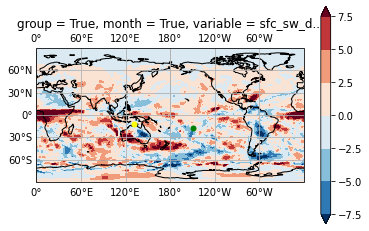

In [214]:
p = cleanupnina2D(surf_isw)
%matplotlib notebook
%matplotlib inline
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude = 180))
p.plot.contourf(robust = True)
ax.coastlines()
plt.gca().gridlines(draw_labels=True)
plate_carree = ccrs.PlateCarree(central_longitude=180)
ax.plot(tahiti_lon, tahiti_lat, markersize=5, marker='o', color='green', transform=ccrs.PlateCarree())
ax.plot(darwin_lon, darwin_lat, markersize=5, marker='o', color='yellow', transform=ccrs.PlateCarree())
plt.savefig('surf_isw_nina_2D')
plt.show()

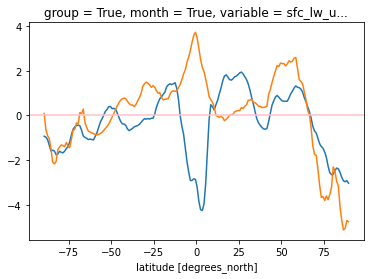

<xarray.DataArray ()>
array(0.34150307)
Coordinates:
    group    bool True
    month    bool True

<Figure size 432x288 with 0 Axes>

In [216]:
%matplotlib notebook
%matplotlib inline
p = cleanupnino1D(toa_olw)
q = cleanupnino1D(surf_olw)
r = cleanupnino1D(cld_area)
s = cleanupnino1D(cld_teff)
t = cleanupnino1D(surf_ilw)
u = cleanupnino1D(surf_isw)
p.plot.line(x='lat')
q.plot.line(x='lat')
plt.axhline(y = 0, color = 'pink')
plt.show()
plt.savefig('toa_surf_olw_corr')
xr.corr(p,q)

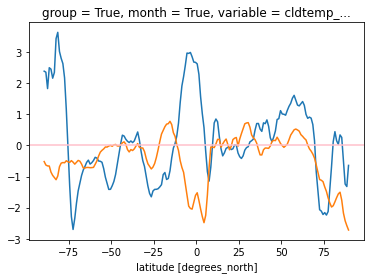

<xarray.DataArray ()>
array(-0.0903652)
Coordinates:
    group    bool True
    month    bool True

In [116]:
%matplotlib notebook
%matplotlib inline
r.plot.line(x='lat')
s.plot.line(x='lat')
plt.axhline(y = 0, color = 'pink')
plt.show()
xr.corr(r,s)

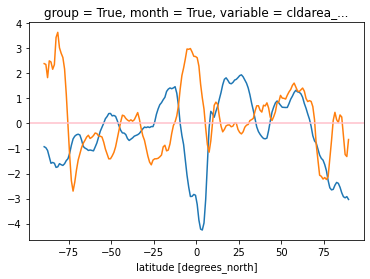

<xarray.DataArray ()>
array(-0.1986637)
Coordinates:
    group    bool True
    month    bool True

<Figure size 432x288 with 0 Axes>

In [217]:
%matplotlib notebook
%matplotlib inline
p.plot.line(x='lat')#toa olr
r.plot.line(x ='lat')#cld area
plt.axhline(y = 0, color = 'pink')
plt.show()
plt.savefig('toa_olr_cld_area_corr')
xr.corr(p,r)

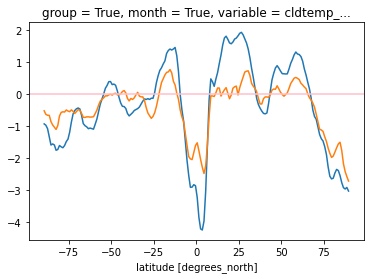

<xarray.DataArray ()>
array(0.92107326)
Coordinates:
    group    bool True
    month    bool True

In [118]:
%matplotlib notebook
%matplotlib inline
p.plot.line(x='lat')
s.plot.line(x ='lat')
plt.axhline(y = 0, color = 'pink')
plt.show()
xr.corr(p,s)

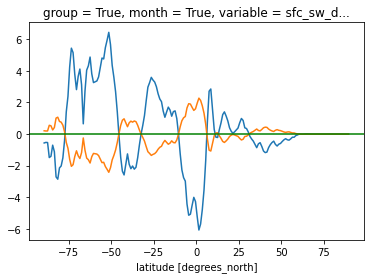

In [122]:
%matplotlib notebook
%matplotlib inline
p = cleanupnino1D(surf_isw)
q = cleanupnina1D(surf_isw)
p.plot.line(x = 'lat')
q.plot.line(x= 'lat')
plt.axhline(y = 0, color = 'green')
plt.show()

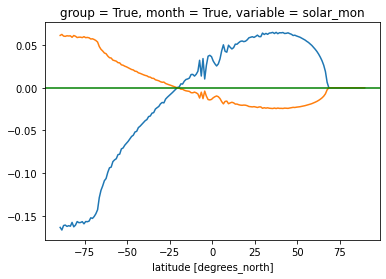

In [123]:
%matplotlib notebook
%matplotlib inline
p = cleanupnino1D(toa_isw)
q = cleanupnina1D(toa_isw)
p.plot.line(x = 'lat')
q.plot.line(x= 'lat')
plt.axhline(y = 0, color = 'green')
plt.show()

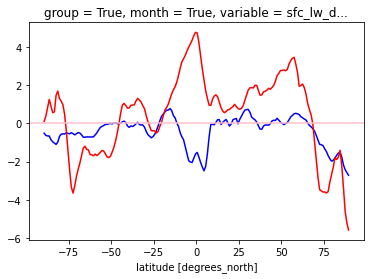

<xarray.DataArray ()>
array(0.34150307)
Coordinates:
    group    bool True
    month    bool True

In [140]:
%matplotlib notebook
%matplotlib inline
s.plot.line(x='lat', color = 'blue')#cld_teff
t.plot.line(x='lat', color = 'red')#surf_olw
plt.axhline(y = 0, color = 'pink')
plt.show()
xr.corr(p,q)
#cld_teff, surf_olw
#the deviation at the equator is weird

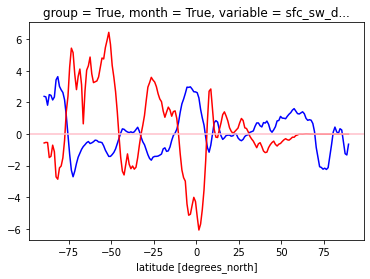

<xarray.DataArray ()>
array(-0.71664089)
Coordinates:
    group    bool True
    month    bool True

In [218]:
%matplotlib notebook
%matplotlib inline
r.plot.line(x='lat', color = 'blue')#cld_teff
u.plot.line(x='lat', color = 'red')#surf_isw
plt.axhline(y = 0, color = 'pink')
plt.show()
xr.corr(r,u)

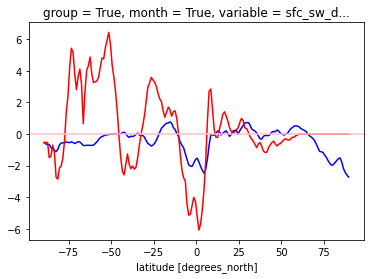

<xarray.DataArray ()>
array(0.31065692)
Coordinates:
    group    bool True
    month    bool True

In [223]:
%matplotlib notebook
%matplotlib inline
s.plot.line(x='lat', color = 'blue')#cld_teff
u.plot.line(x='lat', color = 'red')#surf_isw
plt.axhline(y = 0, color = 'pink')
plt.show()
xr.corr(s,u)

In [186]:
weighted = cleanupnino1D(toa_olw)*da
weightlat = weighted[59:121, :]
weightlat.sum()/0.4

<xarray.DataArray ()>
array(-0.00118003)
Coordinates:
    group     bool True
    month     bool True
    variable  <U14 'toa_lw_all_mon'

In [193]:
weighted = cleanupnino1D(toa_olw)*da
weightlat = weighted[23:157, :]
weightlat.sum()/0.92


<xarray.DataArray ()>
array(0.01937036)
Coordinates:
    group     bool True
    month     bool True
    variable  <U14 'toa_lw_all_mon'

In [142]:
weighted = cleanupnina1D(toa_olw)*da
weighted.sum()

<xarray.DataArray ()>
array(0.03085905)
Coordinates:
    group     bool True
    month     bool True
    variable  <U14 'toa_lw_all_mon'

In [148]:
weighted = cleanupnino1D(surf_olw)*da
weighted.sum()

<xarray.DataArray ()>
array(0.73836715)
Coordinates:
    group     bool True
    month     bool True
    variable  <U17 'sfc_lw_up_all_mon'

In [149]:
weighted =cleanupnina1D(surf_olw)*da
weighted.sum()

<xarray.DataArray ()>
array(-0.27689172)
Coordinates:
    group     bool True
    month     bool True
    variable  <U17 'sfc_lw_up_all_mon'

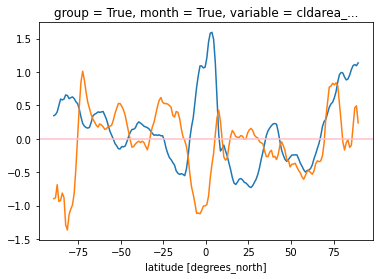

<xarray.DataArray ()>
array(-0.19866615)
Coordinates:
    group    bool True
    month    bool True

<Figure size 432x288 with 0 Axes>

In [227]:
%matplotlib notebook
%matplotlib inline
p = cleanupnina1D(toa_olw)
q = cleanupnina1D(surf_olw)
r = cleanupnina1D(cld_area)
s = cleanupnina1D(cld_teff)
t = cleanupnina1D(surf_ilw)
u = cleanupnina1D(surf_isw)
p.plot.line(x='lat')
r.plot.line(x='lat')
plt.axhline(y = 0, color = 'pink')
plt.show()
plt.savefig('toa_surf_olw_corr')
xr.corr(p,r)